In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G
from galpy.potential import NFWPotential, ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit

G=G.to(u.kpc**3/(u.Msun*u.Gyr**2)).value

[Hui and al. 2017](https://arxiv.org/pdf/1610.08297) have derived the equations of quantum-mechanical treatment of the dynamical friction force. I propose here a new `Python` class to integrate orbits using these theoretical relations with `galpy`.

# Creating a dwarf galaxy dark matter halo potential

In [2]:
M = 1e9 #Msol
rs = 1.57 #kpc
c = 18.4

A_NFW = np.log(1 + c) - c/(1+c)

NFWHalo = NFWPotential(amp=M/A_NFW * u.Msun, a=rs*u.kpc)

# Initialize a globular cluster object

In [3]:
Mobj = 1e6 #Msol
rhm = 1e-2 #kpc

### Dynamical friction

In [4]:
cdf = ChandrasekharDynamicalFrictionForce(GMs=Mobj * u.Msun, rhm=rhm * u.kpc, dens=NFWHalo)

# Initialize the orbit

In [5]:
# initial conditions
R = 0.5
z = 0.
phi = 0. 
Menclosed = NFWHalo.mass(R * u.kpc)
vR = 0.0
vT = np.sqrt(G*Menclosed/R) #km/s
vz = 0. 

o = Orbit([R * u.kpc, vR * u.km/u.s, vT * u.km/u.s, z * u.kpc, vz * u.km/u.s, phi * u.rad])
o_cdf = o() # copy of orbit for dynamical friction
o_fdf = o() # copy of orbit for fuzzy dynamical friction

# Integrate

In [6]:
t = np.linspace(0, 1, 300) * u.Gyr
o.integrate(t, NFWHalo, method='odeint')
o_cdf.integrate(t, NFWHalo + cdf, method='odeint')

# Integrating orbits with Fuzzy Dark Matter (FDM) dynamical friction

The classical dynamical friction force used by `galpy` reads :

$$\vec{F}(\vec{x}, \vec{v}) = -2\pi \left[ \mathcal{G} M_{\rm obj}² \right] \left[ \mathcal{G} \rho(\vec{x}) \right] \ln \Lambda \left[ \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}} \exp \left( -X^2 \right) \right] \frac{\vec{v}}{|\vec{v}|^3}
$$
Using $X = \frac{|\vec{v}|}{\sqrt 2 \sigma(r)}$. And where 
$$\Lambda = \frac{r/\gamma}{\max(r_{\mathrm{hm}}, \mathcal{G}M/|\vec{v}|^2)}$$
Fuzzy dark matter model modifies the dynamical friction force according to the following relation : 
$$\vec{F}_\text{FDM} = -\frac{4\pi\mathcal{G}^2M_\text{obj}^2\rho}{v^3}C(kr)\vec{v}$$
Where the coefficient $C(kr)$ depends on $kr=\frac{mvr}{\hbar}$ and reads : 
$$C(kr) = \text{Cin}(2kr)+\frac{\sin{(2kr)}}{2kr}-1$$
With
$$\text{Cin}(z) = \int_0^z\frac{1-\cos{(t)}}{t}\mathrm{d}t$$

Looking at the classical relation for dynamical friction, the equivalent of the coefficient $C(kr)$ in CDM scenario is : 
$$ C_{\rm CDM} =\frac{1}{2}\ln \Lambda \left[ \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}} \exp \left( -X^2 \right) \right]$$

Since the FDM coefficient $C(kr)$ has an asymptotic behavior, we must use the classical coefficient $C_{\rm CDM}$ as a cutoff whenever $C(kr) \gt C_{\rm CDM}$, because it would mean that we are in the classical regime. This implemented in the class below, on the same model as `galpy` class `ChandrasekharDynamicalFrictionForce`.

In [7]:
from astropy.constants import c, hbar
import hashlib
from galpy.util import conversion
from scipy import interpolate
from galpy.potential.Potential import evaluateDensities
from galpy.potential.Potential import flatten as flatten_pot
from galpy.potential.DissipativeForce import DissipativeForce
from scipy.integrate import quad
import scipy.special as sp

class FDMDynamicalFrictionForce(DissipativeForce):
    def __init__(self,
        amp=1.0,
        GMs=0.1,
        gamma=1.0,
        rhm=0.0,
        m = 1e-22 * u.eV,
        dens=None,
        sigmar=None,
        const_lnLambda=False,
        minr=0.0001,
        maxr=25.0,
        nr=501,
        ro=None,
        vo=None,):
        DissipativeForce.__init__(self, amp=amp * GMs, ro=ro, vo=vo, amp_units="mass")
        rhm = conversion.parse_length(rhm, ro=self._ro)
        minr = conversion.parse_length(minr, ro=self._ro)
        maxr = conversion.parse_length(maxr, ro=self._ro)
        self._gamma = gamma
        self._ms = (
            self._amp / amp
        )  # from handling in __init__ above, should be ms in galpy units
        self._rhm = rhm
        self._minr = minr
        self._maxr = maxr
        self._dens_kwarg = dens  # for pickling
        self._sigmar_kwarg = sigmar  # for pickling
        self._mhbar = (m / (hbar * c**2)).to(1 / (u.kpc * (u.km / u.s))).value *self._ro * self._vo #compute m/hbar
        # Parse density
        dens = flatten_pot(dens)
        self._dens_pot = dens
        self._dens = lambda R, z, phi=0.0, t=0.0: evaluateDensities(
            self._dens_pot, R, z, phi=phi, t=t, use_physical=False
        )
        
        if sigmar is None:
            
            from galpy.df import jeans
            
            sigmar = lambda x: jeans.sigmar(
                self._dens_pot, x, beta=0.0, use_physical=False
            )
        
        self._sigmar_rs_4interp = np.linspace(self._minr, self._maxr, nr)
        self._sigmars_4interp = np.array(
            [sigmar(x) for x in self._sigmar_rs_4interp]
        )
        
        self.sigmar_orig = sigmar
        self.sigmar = interpolate.InterpolatedUnivariateSpline(
            self._sigmar_rs_4interp, self._sigmars_4interp, k=3, check_finite=True
        )
        
        if const_lnLambda:
            self._lnLambda = const_lnLambda
        else:
            self._lnLambda = False
        self._amp *= 4.0 * np.pi
        self._force_hash = None

        return None
    
    def GMs(self, gms):
        gms = conversion.parse_mass(gms, ro=self._ro, vo=self._vo)
        self._amp *= gms / self._ms
        self._ms = gms
        # Reset the hash
        self._force_hash = None
        return None

    GMs = property(None, GMs)

    def rhm(self, new_rhm):
        self._rhm = conversion.parse_length(new_rhm, ro=self._ro)
        # Reset the hash
        self._force_hash = None
        return None

    rhm = property(None, rhm)

    def lnLambda(self, r, v):
        """
        Evaluate the Coulomb logarithm ln Lambda.

        Parameters
        ----------
        r : float
            Spherical radius (natural units).
        v : float
            Current velocity in cylindrical coordinates (natural units).

        Returns
        -------
        lnLambda : float
            Coulomb logarithm.

        Notes
        -----
        - 2018-03-18 - Started - Bovy (UofT)

        """
        if self._lnLambda:
            lnLambda = self._lnLambda
        else:
            GMvs = self._ms / v**2.0
            if GMvs < self._rhm:
                Lambda = r / self._gamma / self._rhm
            else:
                Lambda = r / self._gamma / GMvs
            lnLambda = 0.5 * np.log(1.0 + Lambda**2.0)
        return lnLambda

    def _calc_force(self, R, phi, z, v, t):
        
        r = np.sqrt(R**2.0 + z**2.0)
        if r < self._minr:
            self._cached_force = 0.0
        else:
            vs = np.sqrt(v[0] ** 2.0 + v[1] ** 2.0 + v[2] ** 2.0)
            
            ChandraFactor = self.ChandraFactor(r, vs) #Classical dynamical friction factor
            FDMfactor = self.FDMfactor(r, vs) #FDM dynamical friction factor

            if ChandraFactor/FDMfactor < 1:
                coeff = ChandraFactor
            else:
                coeff = FDMfactor
            
            self._cached_force = (
                -self._dens(R, z, phi=phi, t=t) / vs**3.0 * coeff
            )

    def _Rforce(self, R, z, phi=0.0, t=0.0, v=None):
        
        new_hash = hashlib.md5(
            np.array([R, phi, z, v[0], v[1], v[2], t])
        ).hexdigest()
        if new_hash != self._force_hash:
        
            self._calc_force(R, phi, z, v, t)
        return self._cached_force * v[0]

    def _phitorque(self, R, z, phi=0.0, t=0.0, v=None):
        
        new_hash = hashlib.md5(
            np.array([R, phi, z, v[0], v[1], v[2], t])
        ).hexdigest()
        if new_hash != self._force_hash:
        
            self._calc_force(R, phi, z, v, t)
        return self._cached_force * v[1] * R

    def _zforce(self, R, z, phi=0.0, t=0.0, v=None):
        
        new_hash = hashlib.md5(
            np.array([R, phi, z, v[0], v[1], v[2], t])
        ).hexdigest()
        if new_hash != self._force_hash:
        
            self._calc_force(R, phi, z, v, t)
        return self._cached_force * v[2]
    
    def FDMfactor(self, r, vs):
        """
        Evaluate the FDM dynamical friction factor.
        Parameters
        ----------
        r : float
            Spherical radius (natural units).
        vs : float
            Current velocity in cylindrical coordinates (natural units).
        Returns
        -------
        FDMfactor : float
            FDM dynamical friction factor.
        """
        if self._lnLambda:
            return self._lnLambda
        else :
            kr=self.krValue(r, vs)
            I, _ = quad(lambda t: (1 - np.cos(t)) / t, 0, 2 * kr)
            return I + (np.sin(2 * kr) / (2 * kr)) - 1
    
    def ChandraFactor(self, r, vs):
        """
        Evaluate the classical dynamical friction factor.
        Parameters
        ----------
        r : float
            Spherical radius (natural units).
        vs : float
            Current velocity in cylindrical coordinates (natural units).
        Returns
        -------
        ChandraFactor : float
            Classical dynamical friction factor.
        """
        if r > self._maxr:
                sr = self.sigmar_orig(r)
        else:
                sr = self.sigmar(r)
        X = vs /(np.sqrt(2)* sr)
        Xfactor = sp.erf(X) - 2.0 * X *(1/np.sqrt(np.pi)) * np.exp(-(X**2.0))
        lnLambda = self.lnLambda(r, vs)

        return lnLambda * Xfactor

    def krValue(self, r, v):
        """
        Evaluate the dimensionless kr parameter kr = mrv / hbar. 

        Parameters
        ----------
        r : float
            Spherical radius (natural units).
        v : float
            Current velocity in cylindrical coordinates (natural units).
        Returns
        -------
        kr : float
            Dimensionless kr parameter.
        """
        return self._mhbar * v * r

In [8]:
m = 3e-22 # mass of the fuzzy particle in eV
fdf = FDMDynamicalFrictionForce(GMs=Mobj * u.Msun, rhm=rhm * u.kpc, dens=NFWHalo, m=m*u.eV)

In [9]:
o_fdf.integrate(t, NFWHalo + fdf, method='odeint')

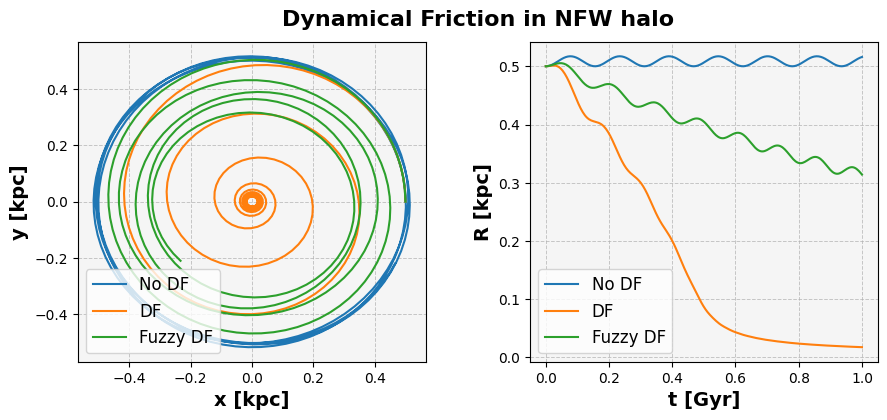

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(o.x(t), o.y(t), label='No DF')
plt.plot(o_cdf.x(t), o_cdf.y(t), label='DF')
plt.plot(o_fdf.x(t), o_fdf.y(t), label='Fuzzy DF')
plt.xlabel('x [kpc]', fontsize=14, fontweight='bold')
plt.ylabel('y [kpc]', fontsize=14, fontweight='bold')
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

plt.subplot(122)
plt.plot(t, o.R(t), label='No DF')
plt.plot(t, o_cdf.R(t), label='DF')
plt.plot(t, o_fdf.R(t), label='Fuzzy DF')
plt.xlabel('t [Gyr]', fontsize=14, fontweight='bold')
plt.ylabel('R [kpc]', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout(pad=2.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

plt.suptitle('Dynamical Friction in NFW halo', fontsize=16, fontweight='bold')
plt.show()

We can clearly see that Fuzzy dark matter dynamical friction is weaker than its classical version. 